# Setup Notebook and GPU

In [ ]:
# Monunt google drive to import KEGG dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setting Colab's GPU
# Edit > Notebook Settings > GPU 
!nvidia-smi -L
# Detailed GPU Information Reference: https://medium.com/analytics-vidhya/the-google-colab-system-specification-check-69d159597417
# !nvidia-smi -q

GPU 0: Tesla V100-SXM2-16GB (UUID: GPU-5a5647ea-5f48-0023-6c78-168b746dc90a)


In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.00GHz


In [ ]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 4
core id		: 0
cpu cores	: 2
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

# Import relevant libraries

In [ ]:
%%capture 
!pip install ampligraph;
%tensorflow_version 1.x 
import numpy as np
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from tabulate import tabulate
ampligraph.__version__

# Import dataset

In [ ]:
# Load the KEGG dataset
df = load_from_csv('.','drive/My Drive/datasets/KEGG/KEGG50K.txt',sep='\t')
headers = ["Head", "Relationship", "Tail"]
table = tabulate(df[:5], headers, tablefmt="fancy_grid") # tabulate data Reference: https://stackoverflow.com/questions/9712085/numpy-pretty-print-tabular-data
print(table) # output

╒══════════╤══════════════════╤═══════════╕
│ Head     │ Relationship     │ Tail      │
╞══════════╪══════════════════╪═══════════╡
│ hsa04024 │ PATHWAY_GENE     │ HSA:51196 │
├──────────┼──────────────────┼───────────┤
│ D02042   │ DRUG_TARGET_GENE │ HSA:5139  │
├──────────┼──────────────────┼───────────┤
│ N00399   │ NETWORK_GENE     │ HSA:2790  │
├──────────┼──────────────────┼───────────┤
│ hsa04912 │ PATHWAY_GENE     │ HSA:6654  │
├──────────┼──────────────────┼───────────┤
│ H00342   │ DISEASE_GENE     │ HSA:6556  │
╘══════════╧══════════════════╧═══════════╛


# Split dataset

In [ ]:
from ampligraph.evaluation import train_test_split_no_unseen 
num_test = int(len(df) * (20 / 100))
data = {}
data['train'], data['test'] = train_test_split_no_unseen(df, test_size=num_test, seed=0, allow_duplication=False) 

In [ ]:
print('Train set size: ', data['train'].shape)
print('Test set size: ', data['test'].shape)

Train set size:  (50464, 3)
Test set size:  (12616, 3)


# Graph embedding algorithm -  HolE

In [ ]:
from ampligraph.latent_features import HolE

#### Creating ComplEx graphical embedding model
*   **k (int)** – Embedding space dimensionality.
*   **eta (int)** – The number of negatives that must be generated at runtime during training for each positive.
*   **epochs (int)** – The iterations of the training loop.
*   **batches_count (int)** – The number of batches in which the training set must be split during the training loop.
*   **seed (int)** – The seed used by the internal random numbers generator.
*   **optimizer (string)** – The optimizer used to minimize the loss function. Choose between ‘sgd’, ‘adagrad’, ‘adam’, ‘momentum’.
*   **optimizer_params (dict)** –
Arguments specific to the optimizer, passed as a dictionary. {’lr’ (float),’momentum’ (float)}
*   **loss (string)** –
The type of loss function to use during training.
*   **regularizer (string)** –
The regularization strategy to use with the loss function
*  **regularizer_params (dict)** –
Dictionary of regularizer-specific hyperparameters. For example, if p=1 the function will perform L1 regularization. L2 regularization is obtained with p=2.
*  **verbose (bool)** – Verbose mode.

In [ ]:
model = HolE(batches_count=100, 
                seed=0, 
                epochs=200, 
                k=200, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll',                     # Multiclass NLL Loss Reference: https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.NLLMulticlass.html#ampligraph.latent_features.NLLMulticlass
                regularizer='LP', 
                regularizer_params={'p':3,'lambda':1e-5},  # The nuclear 3-norm proposed in the ComplEx-N3 from paper LUO18, proves to be effective for DistMult and ComplEx Reference: https://github.com/DeepGraphLearning/KnowledgeGraphEmbedding/issues/6 
                verbose=True)

# Possible loss functions: (Pairwise, max-margin loss),(Absolute margin, max-margin loss),(Self adversarial sampling loss),(Negative log-likelihood loss),(Multiclass NLL Loss),(Binary Cross Entropy Loss)
# Default initializer : Xaviers
# LUO18 : Timothee Lacroix, Nicolas Usunier, and Guillaume Obozinski. Canonical tensor decomposition for knowledge base completion. In International Conference on Machine Learning, 2869–2878. 2018.

#### Filtering negatives
AmpliGraph aims to follow scikit-learn's ease-of-use design philosophy and simplify everything down to fit, evaluate, and predict functions. However, there are some knowledge graph specific steps we must take to ensure our model can be trained and evaluated correctly. The first of these is defining the filter that will be used to ensure that no negative statements generated by the corruption procedure are actually positives. This is simply done by concatenating our train and test sets. Now when negative triples are generated by the corruption strategy, we can check that they aren't actually true statements.

In [ ]:
positives_filter = df

#### Fitting model

In [ ]:
import tensorflow as tf
import time
tf.logging.set_verbosity(tf.logging.ERROR)
start_time = time.time()
model.fit(data['train'], early_stopping = False)
print("Execution time: %s seconds." % (time.time() - start_time))

Average HolE Loss:   0.046153: 100%|██████████| 200/200 [01:26<00:00,  2.30epoch/s]

Execution time: 93.34775495529175 seconds.


#### Saving model

In [ ]:
from ampligraph.latent_features import save_model, restore_model
save_model(model, './HolE_model_Dim200_Adam_Muliclass.pkl')
"""
del model
model = restore_model('./ComplEx_model_Dim200_Adam_Muliclass.pkl')
if model.is_fitted:
    print('The model is fit!')
else:
    print('The model is not fit!')
"""

"\ndel model\nmodel = restore_model('./ComplEx_model_Dim200_Adam_Muliclass.pkl')\nif model.is_fitted:\n    print('The model is fit!')\nelse:\n    print('The model is not fit!')\n"

#### Evaluating model

Parameters of evaluate_performance function of Ampligraph:
- **`X`** - the data to evaluate on. We're going to use our test set to evaluate.
- **`model`** - the model we previously trained.
- **`filter_triples`** - will filter out the false negatives generated by the corruption strategy. 
- **`use_default_protocol`** - specifies whether to use the default corruption protocol. If True, then subj and obj are corrupted separately during evaluation.
- **`verbose`** - will give some nice log statements. Let's leave it on for now.


In [ ]:
from ampligraph.evaluation import evaluate_performance
ranks = evaluate_performance(data['test'], 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True,         # corrupt subj and obj separately while evaluating
                             verbose=True)

100%|██████████| 12616/12616 [01:25<00:00, 146.85it/s]


The ranks returned by the evaluate_performance function indicate the rank at which the test set triple was found when performing link prediction using the model.

We are going to evaluate model using two scores:


*   **mrr_score**: function computes the mean of the reciprocal of elements of a vector of rankings ranks.
*   **hits_at_n_score**: function computes how many elements of a vector of rankings ranks make it to the top n positions.


In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score

mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.42
Hits@10: 0.59
Hits@3: 0.45
Hits@1: 0.33


#### Generating embeddings for entities

In [ ]:
entities = np.unique(np.concatenate([df[:, 0], df[:, 2]]))
relations = np.unique(df[:, 1])

In [ ]:
entity_embeddings = dict(zip(entities, model.get_embeddings(entities)))

In [ ]:
len(entity_embeddings['D00043'])

400

# Link prediction for new entities-relationships

The task of link porediction will help us gather new information about entities and their possible relationship. For example we can perform where a drug and gene are interconnected by relationship 'DRUG_TARGET_GENE' or not.

In [ ]:
# Created few manual samples to check about their feasibility according to our model trained
X_unseen = np.array([
                     ['hsa04024','PATHWAY_GENE','HSA:51196'],     # already in dataset
                     ['D11034','DRUG_EFFICACY_DISEASE','H00409'], # already in dataset
                     ['H00242','DISEASE_GENE','HSA:6338'],        # already in dataset
                     ['D04905','DRUG_TARGET_PATHWAY','hsa05010'], # already in dataset
                     ['N00399','NETWORK_GENE','HSA:2790'],        # already in dataset
                     ['D10845','DRUG_TARGET_PATHWAY','hsa04610'], # already in dataset
                     ['N00060','NETWORK_GENE','HSA:23401'],       # already in dataset
                     ['hsa04024','PATHWAY_GENE','HSA:6336'],      # not in dataset, but might be possible
                     ['D11056','DRUG_TARGET_GENE','HSA:7388'],    # not in dataset, but might be possible
                     ['D11056','DRUG_TARGET_GENE','HSA:3352'],    # not in dataset, but might be possible
                     ['H00242','DISEASE_GENE','HSA:6788'],        # not in dataset, but might be possible
                     ['D04905','DRUG_TARGET_PATHWAY','hsa04728'], # not in dataset, but might be possible
                     ['N00399','NETWORK_GENE','HSA:9217'],        # not in dataset, but might be possible
                     ['D10845','DRUG_TARGET_PATHWAY','hsa05230'], # not in dataset, but might be possible
                     ['N00060','NETWORK_GENE','HSA:5600'],        # not in dataset, but might be possible
                     ['N00327','DISEASE_PATHWAY','HSA:109'],      # impossible
                     ['H00242','DISEASE_GENE','D11034'],          # impossible
                     ['D04905','DRUG_TARGET_PATHWAY','N00399'],   # impossible
                     ['N00399','NETWORK_GENE','N00399'],          # impossible
                     ['D10845','DRUG_TARGET_PATHWAY','D07257'],   # impossible
                     ['N00060','DRUG_TARGET_PATHWAY','hsa04380']  # impossible
])

In [ ]:
unseen_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))

In [ ]:
ranks_unseen = evaluate_performance(
    X_unseen, 
    model=model, 
    filter_triples=unseen_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True
)

100%|██████████| 21/21 [00:00<00:00, 94.87it/s]


In [ ]:
ranks_unseen

array([  384,     1,     1,     1,     2,     1,     1, 11902, 20288,
          63, 15489,    48, 23613,  3044,  1053,  6503, 22378,  1225,
        5126,  4167, 29731], dtype=int32)

In [ ]:
scores = model.predict(X_unseen)

Transforming scores which are in real numbers to probablities (0-1) range for better understanding and comparisions using expit transformation. Although, the probablities are not calibrated.

In [ ]:
scores # direct scores, hard to get insights from these

array([ 6.614034  ,  7.0816627 ,  6.761378  ,  7.251428  ,  9.021282  ,
        8.3052025 ,  8.316853  ,  0.19554111, -0.14008857,  6.453208  ,
       -0.0376883 ,  5.947709  , -0.4940168 ,  0.5333029 ,  3.1433427 ,
        0.17501946, -0.14705503,  0.54021543,  0.7831328 ,  0.20062931,
       -0.8973551 ], dtype=float32)

In [ ]:
from scipy.special import expit
probs = expit(scores)

In [ ]:
pd.DataFrame(list(zip([' '.join(x) for x in X_unseen],
                      ranks_unseen,
                      np.squeeze(scores),
                      np.squeeze(probs))),
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score")

,statement,rank,score,prob
20,N00060 DRUG_TARGET_PATHWAY hsa04380,29731,-0.897355,0.289594
12,N00399 NETWORK_GENE HSA:9217,23613,-0.494017,0.378948
16,H00242 DISEASE_GENE D11034,22378,-0.147055,0.463302
8,D11056 DRUG_TARGET_GENE HSA:7388,20288,-0.140089,0.465035
10,H00242 DISEASE_GENE HSA:6788,15489,-0.037688,0.490579
15,N00327 DISEASE_PATHWAY HSA:109,6503,0.175019,0.543644
7,hsa04024 PATHWAY_GENE HSA:6336,11902,0.195541,0.548730
19,D10845 DRUG_TARGET_PATHWAY D07257,4167,0.200629,0.549990
13,D10845 DRUG_TARGET_PATHWAY hsa05230,3044,0.533303,0.630253
17,D04905 DRUG_TARGET_PATHWAY N00399,1225,0.540215,0.631863


# Visualisation of embedding in lower dimensions

In [ ]:
%%capture
!pip install seaborn adjustText
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
%matplotlib inline

Using PCA as a dimensionality reduction algorithm. Principal Component Analysis (PCA) is an unsupervised, non-parametric statistical technique primarily used for dimensionality reduction in machine learning.

In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in entity_embeddings.values()]))
embeddings_2d[:2]

array([[-2.3947453,  1.8237693],
       [-3.6367016,  3.6950302]], dtype=float32)

In [ ]:
embeddings_2d[0]

array([-2.3947453,  1.8237693], dtype=float32)

##### Plotting in 2D space based on entity type

In [ ]:
def entityType(n):         # Utility functon to return entity type
  if n.startswith("h"):
    return "PATHWAY"
  elif n.startswith("D"):
    return "DRUG"
  elif n.startswith("N"):
    return "NETWORK"
  elif n.startswith("HS"):
    return "GENE"
  else:
    return "DISEASE"

In [ ]:
entityTypeList = list(map(entityType,entities))
print(pd.DataFrame({"Entity": entities[:5],"Type":entityTypeList[:5]}))

   Entity  Type
0  D00043  DRUG
1  D00045  DRUG
2  D00049  DRUG
3  D00058  DRUG
4  D00059  DRUG


In [ ]:
entityType_df = pd.DataFrame({"entity": entities,
                "type":entityTypeList,
                "embedding1": embeddings_2d[:, 0], 
                "embedding2": embeddings_2d[:, 1],
                })
entityType_df

,entity,type,embedding1,embedding2
0,D00043,DRUG,-2.394745,1.823769
1,D00045,DRUG,-3.636702,3.695030
2,D00049,DRUG,-4.817039,-2.099682
3,D00058,DRUG,-3.361814,3.641068
4,D00059,DRUG,-4.627749,4.910399
...,...,...,...,...
16196,hsa05410,PATHWAY,-1.346693,3.210038
16197,hsa05412,PATHWAY,-1.507813,2.815703
16198,hsa05414,PATHWAY,-1.583071,3.564325
16199,hsa05416,PATHWAY,-0.400119,2.595646


In [ ]:
def plot_clusters(hue,df):
  np.random.seed(0)
  plt.figure(figsize=(12, 12))
  plt.title("{} embeddings".format(hue).capitalize())
  ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue=hue)

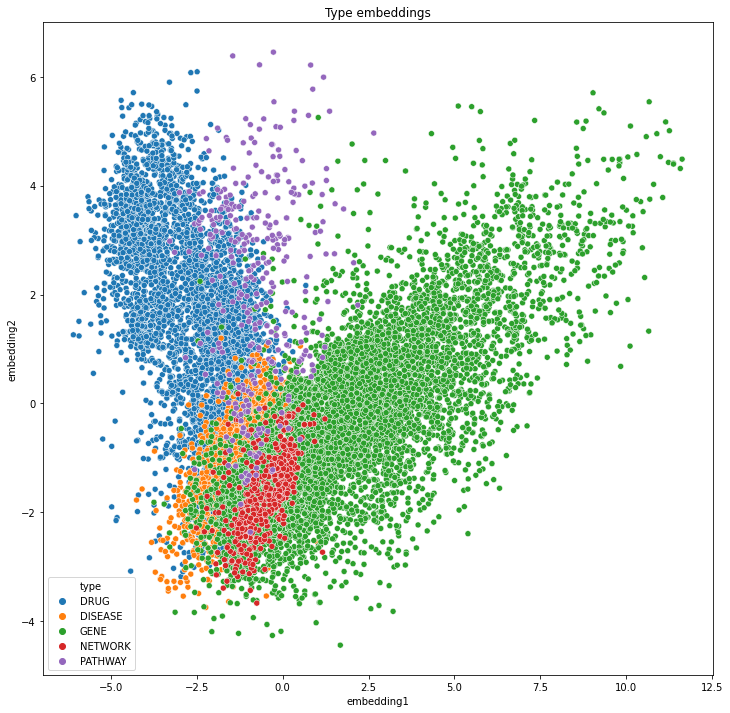

In [ ]:
plot_clusters("type",entityType_df)

# Clustering and plotting

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

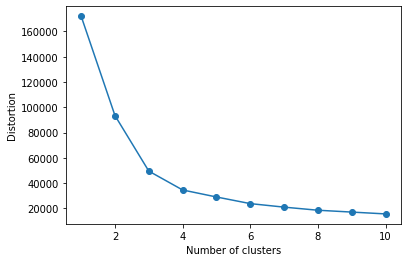

In [ ]:
# https://github.com/prakhargurawa/Machine-Learning-A-Z/blob/main/4_Clustering/k_means_clustering.py
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
WCSS = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, n_init=50, max_iter=500, random_state=0,init = 'k-means++')
    km.fit(embeddings_2d)
    WCSS.append(km.inertia_)

# plot
plt.plot(range(1, 11), WCSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
# 3 is perfect for now

In [ ]:
clustering_algorithm = KMeans(n_clusters=3, n_init=50, max_iter=500, random_state=0,init = 'k-means++')
clusters = find_clusters(entities, model, clustering_algorithm, mode='entity')

In [ ]:
plot_df = pd.DataFrame({"entity": entities, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})
plot_df

,entity,embedding1,embedding2,cluster
0,D00043,-2.394746,1.823789,cluster2
1,D00045,-3.636702,3.695029,cluster2
2,D00049,-4.817040,-2.099691,cluster1
3,D00058,-3.361814,3.641064,cluster2
4,D00059,-4.627749,4.910397,cluster2
...,...,...,...,...
16196,hsa05410,-1.346693,3.210041,cluster1
16197,hsa05412,-1.507814,2.815706,cluster1
16198,hsa05414,-1.583071,3.564329,cluster1
16199,hsa05416,-0.400119,2.595649,cluster1


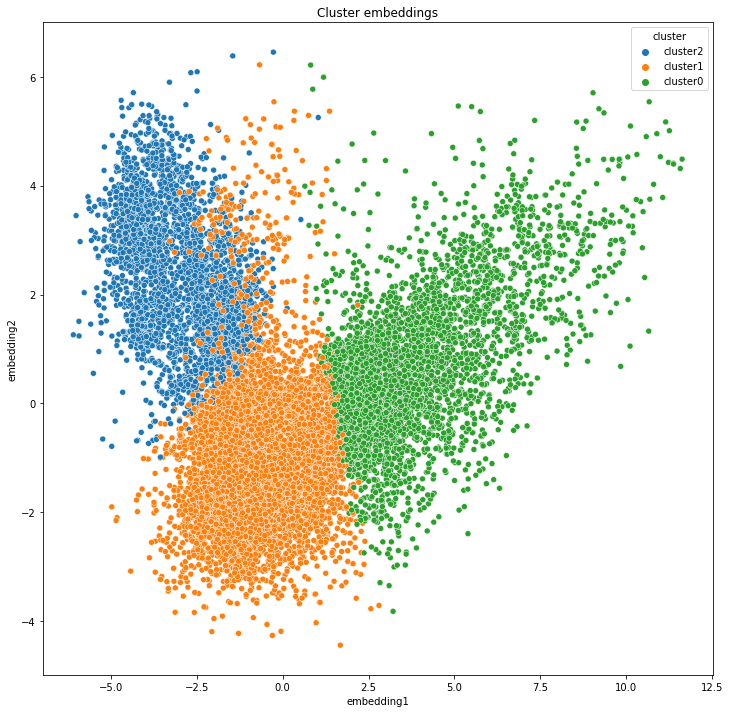

In [ ]:
plot_clusters("cluster",plot_df)

# Model Selection/ Hyperparameter settings

In [ ]:
import itertools
tf.logging.set_verbosity(tf.logging.ERROR)

ks = [100,200,300]                # dimension of embeddings         
optimizers = ['adam','sgd']       # adam optimizer and stochastic gradient optimizer
optimizers = ['adam']             # adam optimizer 
losss = ['multiclass_nll','bce']  # Multiclass NLL loss and Binary cross entropy loss 
losss = ['multiclass_nll']        # Multiclass NLL loss    
lrs = [1e-3,1e-1]                 # Learning rate for optimizers 
lambdas = [1e-5,1e-2,1e-1]        # regularization constants
ps = [1,2,3]                      # L1,L2 or L3 (nuclear 3-norm) regularization

i = 0
for k,optimizer,loss,lr,lam,p in itertools.product(ks,optimizers,losss,lrs,lambdas,ps):
  print("\n################################################################################################################\n")
  try:
    print("Model configs ( Embedding size : ",k,", Optimizer : ",optimizer,", with learning rate : ",lr,", Loss : ",loss,",regularization type: ",p," regularization constant lambda: ",lam," )")
    model = HolE(batches_count=100, 
                  seed=0, 
                  epochs=200, 
                  k=k, 
                  eta=5,
                  optimizer=optimizer, 
                  optimizer_params={'lr':lr},
                  loss=loss,                                 # Multiclass NLL Loss Reference: https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.NLLMulticlass.html#ampligraph.latent_features.NLLMulticlass
                  regularizer='LP', 
                  regularizer_params={'p':p, 'lambda':lam},  # The nuclear 3-norm proposed in the ComplEx-N3 from paper LUO18, proves to be effective for DistMult and ComplEx Reference: https://github.com/DeepGraphLearning/KnowledgeGraphEmbedding/issues/6 
                  verbose=False)
    
    start_time = time.time()
    model.fit(data['train'], early_stopping = False)
    print("Execution time: %s seconds." % (time.time() - start_time))
    
    # modelname = './TransE_model_'+str(i)+'.pkl'
    # print("Model saved as :",modelname)
    # save_model(model, modelname)
    print("Number : ",i)
    i=i+1

    ranks = evaluate_performance(data['test'],model=model,filter_triples=positives_filter,use_default_protocol=True,verbose=True)

    mrr = mrr_score(ranks)
    print("MRR: %.2f" % (mrr))
    hits_10 = hits_at_n_score(ranks, n=10)
    print("Hits@10: %.2f" % (hits_10))
    hits_3 = hits_at_n_score(ranks, n=3)
    print("Hits@3: %.2f" % (hits_3))
    hits_1 = hits_at_n_score(ranks, n=1)
    print("Hits@1: %.2f" % (hits_1))  
  except Exception as e:
    print("This configuration didn't worked out due to some technical error: ",e)
  print("\n################################################################################################################\n")


################################################################################################################

Model configs ( Embedding size :  100 , Optimizer :  adam , with learning rate :  0.001 , Loss :  multiclass_nll ,regularization type:  1  regularization constant lambda:  1e-05  )
Execution time: 98.73641896247864 seconds.
Number :  0
MRR: 0.00
Hits@10: 0.00
Hits@3: 0.00
Hits@1: 0.00

################################################################################################################


################################################################################################################

Model configs ( Embedding size :  100 , Optimizer :  adam , with learning rate :  0.001 , Loss :  multiclass_nll ,regularization type:  2  regularization constant lambda:  1e-05  )
Execution time: 97.39461946487427 seconds.
Number :  1
MRR: 0.39
Hits@10: 0.56
Hits@3: 0.42
Hits@1: 0.31

##################################################################################

# Working with best model

After testing the model with different hyperparameters, we are going to us ethe best performing model from now.




In [ ]:
"""
Model configs ( Embedding size :  300 , Optimizer :  adam , with learning rate :  0.001 , Loss :  multiclass_nll ,regularization type:  3  regularization constant lambda:  1e-05  )
Execution time: 138.68916082382202 seconds.
Number :  32
MRR: 0.43
Hits@10: 0.61
Hits@3: 0.46
Hits@1: 0.34
"""
model = HolE(batches_count=100, 
                seed=0, 
                epochs=200, 
                k=300, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll',                     # Multiclass NLL Loss Reference: https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.NLLMulticlass.html#ampligraph.latent_features.NLLMulticlass
                regularizer='LP', 
                regularizer_params={'p':3,'lambda':1e-5},  # The nuclear 3-norm proposed in the ComplEx-N3 from paper LUO18, proves to be effective for DistMult and ComplEx Reference: https://github.com/DeepGraphLearning/KnowledgeGraphEmbedding/issues/6 
                verbose=False)

# Possible loss functions: (Pairwise, max-margin loss),(Absolute margin, max-margin loss),(Self adversarial sampling loss),(Negative log-likelihood loss),(Multiclass NLL Loss),(Binary Cross Entropy Loss)
# Default initializer : Xaviers
# LUO18 : Timothee Lacroix, Nicolas Usunier, and Guillaume Obozinski. Canonical tensor decomposition for knowledge base completion. In International Conference on Machine Learning, 2869–2878. 2018.

In [ ]:
import tensorflow as tf
import time
tf.logging.set_verbosity(tf.logging.ERROR)
start_time = time.time()
model.fit(data['train'], early_stopping = False)
print("Execution time: %s seconds." % (time.time() - start_time))

Execution time: 130.1184253692627 seconds.


In [ ]:
from ampligraph.latent_features import save_model, restore_model
save_model(model, './HolE_Best_Model')

In [ ]:
from ampligraph.evaluation import evaluate_performance
ranks = evaluate_performance(data['test'], 
                             model=model, 
                             filter_triples=positives_filter,   # Corruption strategy filter defined above 
                             use_default_protocol=True,         # corrupt subj and obj separately while evaluating
                             verbose=True)

In [ ]:
from ampligraph.evaluation import mr_score, mrr_score, hits_at_n_score
mrr = mrr_score(ranks)
print("MRR: %.2f" % (mrr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

MRR: 0.43
Hits@10: 0.61
Hits@3: 0.46
Hits@1: 0.34


In [ ]:
entity_embeddings = dict(zip(entities, model.get_embeddings(entities)))

In [ ]:
len(entity_embeddings['D00043'])

600

In [ ]:
unseen_filter = np.array(list({tuple(i) for i in np.vstack((positives_filter, X_unseen))}))

In [ ]:
ranks_unseen = evaluate_performance(
    X_unseen, 
    model=model, 
    filter_triples=unseen_filter,   # Corruption strategy filter defined above 
    corrupt_side = 's+o',
    use_default_protocol=False, # corrupt subj and obj separately while evaluating
    verbose=True
)

In [ ]:
ranks_unseen

array([  183,     1,     1,     1,     2,     1,     2, 13484,  2838,
          58, 10523,    45, 24857,  3822,   881,  2113, 18994, 28735,
       10855,  2076, 32177], dtype=int32)

In [ ]:
scores = model.predict(X_unseen)

In [ ]:
scores # direct scores, hard to get insights from these

array([ 7.1482596 ,  6.6213374 ,  6.2571626 ,  6.6902475 ,  8.310098  ,
        7.9489684 ,  7.5854445 ,  0.01383723,  0.34760055,  5.761334  ,
        0.0558499 ,  5.6622186 , -0.57746917,  0.3039294 ,  3.1446962 ,
        0.29606625, -0.07063317, -0.32226142,  0.12926476,  0.2801882 ,
       -1.4023077 ], dtype=float32)

In [ ]:
from scipy.special import expit
probs = expit(scores)
pd.DataFrame(list(zip([' '.join(x) for x in X_unseen],
                      ranks_unseen,
                      np.squeeze(scores),
                      np.squeeze(probs))),
             columns=['statement', 'rank', 'score', 'prob']).sort_values("score")

,statement,rank,score,prob
20,N00060 DRUG_TARGET_PATHWAY hsa04380,32177,-1.402308,0.197450
12,N00399 NETWORK_GENE HSA:9217,24857,-0.577469,0.359515
17,D04905 DRUG_TARGET_PATHWAY N00399,28735,-0.322261,0.420125
16,H00242 DISEASE_GENE D11034,18994,-0.070633,0.482349
7,hsa04024 PATHWAY_GENE HSA:6336,13484,0.013837,0.503459
10,H00242 DISEASE_GENE HSA:6788,10523,0.055850,0.513959
18,N00399 NETWORK_GENE N00399,10855,0.129265,0.532271
19,D10845 DRUG_TARGET_PATHWAY D07257,2076,0.280188,0.569592
15,N00327 DISEASE_PATHWAY HSA:109,2113,0.296066,0.573481
13,D10845 DRUG_TARGET_PATHWAY hsa05230,3822,0.303929,0.575403


In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in entity_embeddings.values()]))
embeddings_2d[:2]

array([[-2.6988425,  1.6554356],
       [-4.7157955,  4.4784555]], dtype=float32)

In [ ]:
entityTypeList = list(map(entityType,entities))
print(pd.DataFrame({"Entity": entities[:5],"Type":entityTypeList[:5]}))

   Entity  Type
0  D00043  DRUG
1  D00045  DRUG
2  D00049  DRUG
3  D00058  DRUG
4  D00059  DRUG


In [ ]:
entityType_df = pd.DataFrame({"entity": entities,
                "type":entityTypeList,
                "embedding1": embeddings_2d[:, 0], 
                "embedding2": embeddings_2d[:, 1],
                })
entityType_df

,entity,type,embedding1,embedding2
0,D00043,DRUG,-2.698843,1.655436
1,D00045,DRUG,-4.715796,4.478456
2,D00049,DRUG,-5.636177,-1.018874
3,D00058,DRUG,-3.979644,4.466144
4,D00059,DRUG,-5.465235,5.760655
...,...,...,...,...
16196,hsa05410,PATHWAY,0.403430,0.596239
16197,hsa05412,PATHWAY,0.206612,0.614432
16198,hsa05414,PATHWAY,-0.222174,1.121198
16199,hsa05416,PATHWAY,-0.007035,-0.056477


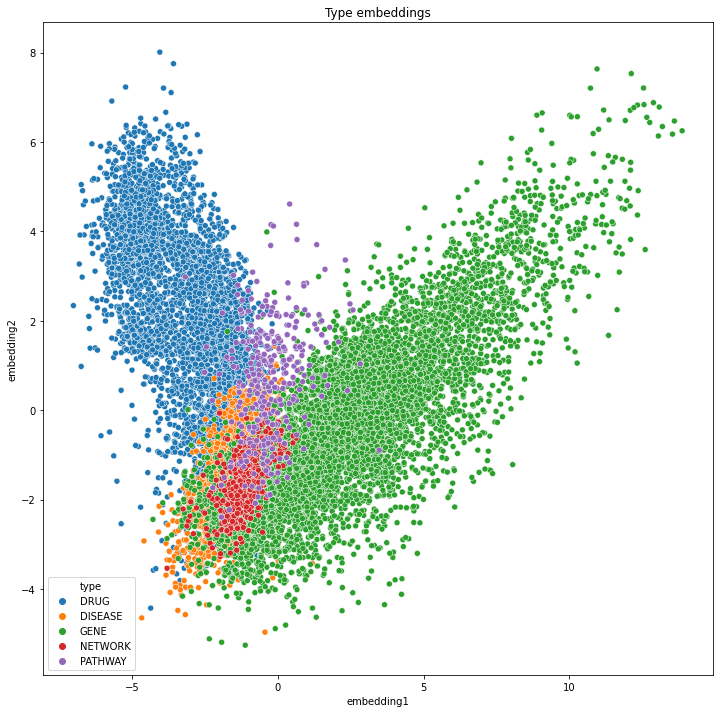

In [ ]:
def plot_clusters(hue,df,saved=False,figname='default.png'):
  np.random.seed(0)
  plt.figure(figsize=(12, 12))
  plt.title("{} embeddings".format(hue).capitalize())
  ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue=hue)
  if saved==True:
    plt.savefig(figname,bbox_inches = 'tight')
plot_clusters("type",entityType_df,saved=True,figname="HolE2DEntity.png")

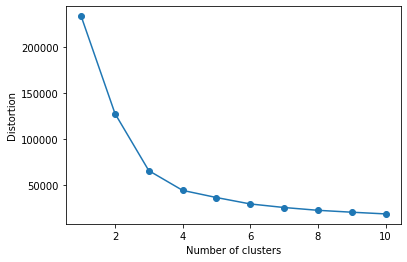

In [ ]:
# https://github.com/prakhargurawa/Machine-Learning-A-Z/blob/main/4_Clustering/k_means_clustering.py
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
WCSS = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, n_init=50, max_iter=500, random_state=0,init = 'k-means++')
    km.fit(embeddings_2d)
    WCSS.append(km.inertia_)

# plot
plt.plot(range(1, 11), WCSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
# 4 is perfect for now

In [ ]:
clustering_algorithm = KMeans(n_clusters=3, n_init=50, max_iter=500, random_state=0,init = 'k-means++')
clusters = find_clusters(entities, model, clustering_algorithm, mode='entity')

In [ ]:
plot_df = pd.DataFrame({"entity": entities, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})
plot_df

,entity,embedding1,embedding2,cluster
0,D00043,-2.698843,1.655424,cluster0
1,D00045,-4.715797,4.478456,cluster0
2,D00049,-5.636177,-1.018873,cluster0
3,D00058,-3.979643,4.466145,cluster0
4,D00059,-5.465237,5.760655,cluster0
...,...,...,...,...
16196,hsa05410,0.403429,0.596237,cluster1
16197,hsa05412,0.206611,0.614431,cluster1
16198,hsa05414,-0.222175,1.121196,cluster1
16199,hsa05416,-0.007036,-0.056478,cluster1


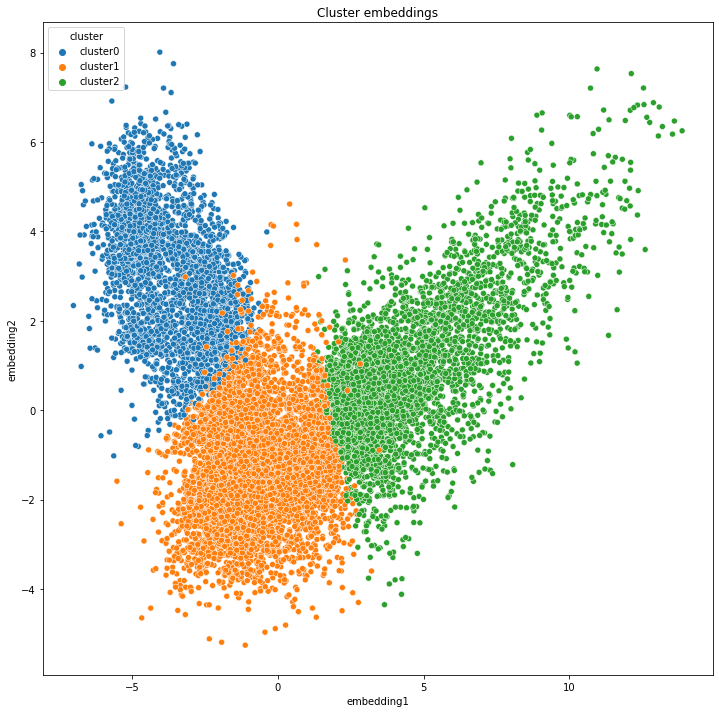

In [ ]:
plot_clusters("cluster",plot_df)